In [287]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from re import search

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

In [2]:
raw_data = pd.read_csv('../data/listings.csv')

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10109 entries, 0 to 10108
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            10109 non-null  int64  
 1   listing_url                                   10109 non-null  object 
 2   scrape_id                                     10109 non-null  int64  
 3   last_scraped                                  10109 non-null  object 
 4   name                                          10109 non-null  object 
 5   description                                   9910 non-null   object 
 6   neighborhood_overview                         6480 non-null   object 
 7   picture_url                                   10108 non-null  object 
 8   host_id                                       10109 non-null  int64  
 9   host_url                                      10109 non-null 

In [4]:
raw_data['price'].value_counts().sort_values(ascending=False)

$150.00      258
$100.00      216
$200.00      215
$75.00       177
$250.00      161
            ... 
$1,073.00      1
$3,189.00      1
$1,850.00      1
$779.00        1
$522.00        1
Name: price, Length: 879, dtype: int64

In [5]:
to_drop_columns = ['id',
                   'listing_url',
                   'scrape_id',
                   'last_scraped',
                   'name',
                   'description',
                   'neighborhood_overview',
                   'picture_url',
                   'host_id',
                   'host_url',
                   'host_name',
                   'host_since',
                   'host_location',
                   'host_about',
                   'host_response_time',
                   'host_response_rate',
                   'host_acceptance_rate',
                   'host_thumbnail_url',
                   'host_picture_url',
                   'host_neighbourhood',
                   'host_listings_count',
                   'host_total_listings_count',
                   'host_verifications',
                   'host_has_profile_pic',
                   'neighbourhood',
                   'neighbourhood_group_cleansed',
                   'bathrooms',
                   'minimum_minimum_nights',
                   'maximum_minimum_nights',
                   'minimum_maximum_nights',
                   'maximum_maximum_nights',
                   'minimum_nights_avg_ntm',
                   'maximum_nights_avg_ntm',
                   'calendar_updated',
                   'calendar_last_scraped'
                   'license',
                  ]

In [6]:
to_try = ['latitude',
          'longitude',
          'property_type',
          'has_availability',
          'availability_30',
          'availability_60',
          'number_of_reviews_ltm',
          'first_review',
          'last_review',
          'calculated_host_listings_count_entire_homes',
          'calculated_host_listings_count_private_rooms',
          'calculated_host_listings_count_shared_rooms'
         ]

In [7]:
to_keep = ['host_is_superhost',
           'host_identity_verified',
           'neighbourhood_cleansed',
           'room_type',
           'accommodates',
           'bathrooms_text',
           'bedrooms',
           'beds',
           'amenities',
           'price',
           'minimum_nights',
           'maximum_nights',
           'availability_90',
           'availability_365',
           'number_of_reviews',
           'number_of_reviews_l30d',
           'review_scores_rating',
           'review_scores_accuracy',
           'review_scores_cleanliness',
           'review_scores_checkin',
           'review_scores_communication',
           'review_scores_location',
           'review_scores_value',
           'instant_bookable',
           'calculated_host_listings_count',
           'reviews_per_month'
          ]

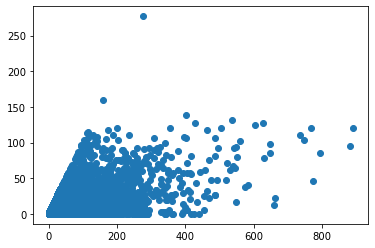

In [8]:
fig, ax = plt.subplots()
ax.scatter(raw_data['number_of_reviews'], raw_data['number_of_reviews_ltm'])

In [9]:
raw_to_keep = raw_data.loc[:, to_keep]

In [10]:
raw_to_keep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10109 entries, 0 to 10108
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_is_superhost               9814 non-null   object 
 1   host_identity_verified          9814 non-null   object 
 2   neighbourhood_cleansed          10109 non-null  int64  
 3   room_type                       10109 non-null  object 
 4   accommodates                    10109 non-null  int64  
 5   bathrooms_text                  10094 non-null  object 
 6   bedrooms                        9425 non-null   float64
 7   beds                            9886 non-null   float64
 8   amenities                       10109 non-null  object 
 9   price                           10109 non-null  object 
 10  minimum_nights                  10109 non-null  int64  
 11  maximum_nights                  10109 non-null  int64  
 12  availability_90                 

In [11]:
clean_to_keep = raw_to_keep.copy()

In [12]:
clean_to_keep['price'] = clean_to_keep['price'].apply(lambda x: x.replace('$', ''))
clean_to_keep['price'] = clean_to_keep['price'].apply(lambda x: x.replace(',', ''))
clean_to_keep['price'] = clean_to_keep['price'].astype('float64')

In [13]:
clean_to_keep['host_is_superhost'] = (clean_to_keep['host_is_superhost'] == 't')

In [14]:
clean_to_keep['host_identity_verified'] = (clean_to_keep['host_identity_verified'] == 't')

In [15]:
clean_to_keep['entire_home'] = (clean_to_keep['room_type'] == 'Entire home/apt')
clean_to_keep.drop(columns='room_type', inplace=True)

In [16]:
clean_to_keep['shared_bathroom'] = clean_to_keep['bathrooms_text'].str.contains('shared')
clean_to_keep['shared_bathroom'] = clean_to_keep['shared_bathroom'].astype('bool')

In [17]:
clean_to_keep['bathrooms_text'] = clean_to_keep['bathrooms_text'].str.lower()
clean_to_keep['bathrooms_text'] = clean_to_keep['bathrooms_text'].str.replace('private ', '')
clean_to_keep['bathrooms_text'] = clean_to_keep['bathrooms_text'].str.replace('shared ', '')
clean_to_keep['bathrooms_text'] = clean_to_keep['bathrooms_text'].str.replace('half-bath', '0.5')
clean_to_keep['bathrooms_text'] = clean_to_keep['bathrooms_text'].str.replace(' bath', '')
clean_to_keep['bathrooms_text'] = clean_to_keep['bathrooms_text'].str.replace('s', '')
clean_to_keep['bathrooms'] = clean_to_keep['bathrooms_text'].astype('float64')

In [18]:
clean_to_keep['bathrooms'].value_counts()

1.0     5881
2.0     2026
2.5      690
1.5      628
3.0      374
3.5      160
4.0      119
4.5       69
5.0       33
0.0       32
5.5       24
6.0       16
6.5       14
0.5       14
7.0        4
8.0        4
7.5        3
9.0        1
17.0       1
10.5       1
Name: bathrooms, dtype: int64

In [19]:
clean_to_keep['instant_bookable'] = (clean_to_keep['instant_bookable'] == 't')

In [20]:
clean_to_keep.drop(columns='bathrooms_text', inplace=True)

In [21]:
clean_to_keep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10109 entries, 0 to 10108
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_is_superhost               10109 non-null  bool   
 1   host_identity_verified          10109 non-null  bool   
 2   neighbourhood_cleansed          10109 non-null  int64  
 3   accommodates                    10109 non-null  int64  
 4   bedrooms                        9425 non-null   float64
 5   beds                            9886 non-null   float64
 6   amenities                       10109 non-null  object 
 7   price                           10109 non-null  float64
 8   minimum_nights                  10109 non-null  int64  
 9   maximum_nights                  10109 non-null  int64  
 10  availability_90                 10109 non-null  int64  
 11  availability_365                10109 non-null  int64  
 12  number_of_reviews               

In [22]:
clean_to_keep.corr()

,host_is_superhost,host_identity_verified,neighbourhood_cleansed,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,availability_90,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,entire_home,shared_bathroom,bathrooms
host_is_superhost,1.000000,0.116597,0.008777,0.031364,0.038240,0.041948,-0.065444,0.035279,-0.065490,0.052779,...,0.154995,0.160996,0.162142,0.242561,0.055286,0.134353,0.290250,0.113364,-0.052662,-0.006977
host_identity_verified,0.116597,1.000000,-0.018405,0.001204,-0.007321,-0.008157,-0.008562,0.026214,-0.000302,0.025992,...,-0.010497,-0.001803,0.007402,0.005000,0.052797,0.134589,0.024839,0.014440,0.014000,-0.013209
neighbourhood_cleansed,0.008777,-0.018405,1.000000,-0.067625,-0.027620,-0.039549,-0.069560,0.044551,-0.015904,-0.004474,...,-0.014493,-0.016492,-0.092207,0.030182,-0.033100,0.097279,-0.060300,-0.166656,0.143966,-0.008037
accommodates,0.031364,0.001204,-0.067625,1.000000,0.844689,0.738495,0.421576,-0.056903,0.051434,0.087668,...,0.016830,-0.019400,-0.002149,-0.061344,0.137327,0.003100,0.022475,0.409236,-0.273686,0.722016
bedrooms,0.038240,-0.007321,-0.027620,0.844689,1.000000,0.763515,0.462555,-0.020995,0.036026,0.045395,...,0.048651,0.006233,0.017511,-0.011177,0.045507,-0.037783,-0.037105,0.370443,-0.233346,0.830734
beds,0.041948,-0.008157,-0.039549,0.738495,0.763515,1.000000,0.390254,-0.029900,0.048640,0.074204,...,0.016376,-0.023350,0.003020,-0.046901,0.107615,0.013616,0.017033,0.253483,-0.164288,0.657632
price,-0.065444,-0.008562,-0.069560,0.421576,0.462555,0.390254,1.000000,-0.005078,0.003219,0.067956,...,0.015653,0.004912,0.015412,-0.048276,0.012165,-0.008311,-0.080124,0.153408,-0.123304,0.495174
minimum_nights,0.035279,0.026214,0.044551,-0.056903,-0.020995,-0.029900,-0.005078,1.000000,0.005498,0.043205,...,0.024381,0.013573,0.023489,0.006099,0.006762,0.214562,-0.093213,0.030031,0.000205,0.002997
maximum_nights,-0.065490,-0.000302,-0.015904,0.051434,0.036026,0.048640,0.003219,0.005498,1.000000,-0.007577,...,-0.026748,-0.025343,-0.021314,-0.062725,0.016220,0.007461,-0.012371,0.036524,-0.027322,0.027470
availability_90,0.052779,0.025992,-0.004474,0.087668,0.045395,0.074204,0.067956,0.043205,-0.007577,1.000000,...,-0.065694,-0.079992,-0.026909,-0.105478,0.106163,0.162491,0.237384,0.047511,-0.002600,0.040574


In [23]:
clean_to_keep['neighbourhood_cleansed'].value_counts()

78704    1798
78702    1236
78701     752
78741     625
78703     514
78745     492
78705     484
78751     455
78723     328
78758     262
78746     259
78734     217
78757     200
78721     199
78722     171
78744     166
78748     142
78756     130
78752     124
78729     116
78731     116
78754     114
78735     107
78749     102
78727     100
78737      98
78753      96
78759      87
78733      68
78724      62
78717      62
78728      56
78732      55
78736      50
78738      47
78747      45
78750      44
78725      41
78730      36
78739      27
78726      12
78742       7
78719       6
78712       1
Name: neighbourhood_cleansed, dtype: int64

<AxesSubplot:xlabel='neighbourhood_cleansed', ylabel='price'>

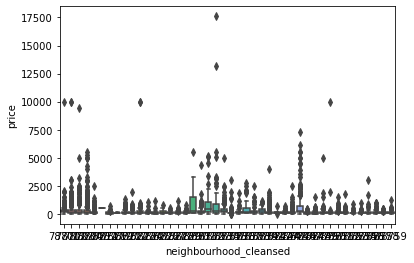

In [24]:
sns.boxplot(x='neighbourhood_cleansed', y='price', data=clean_to_keep)

In [25]:
clean_to_keep.describe()

,neighbourhood_cleansed,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,availability_90,availability_365,number_of_reviews,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,bathrooms
count,10109.000000,10109.000000,9425.000000,9886.000000,10109.000000,10109.00000,10109.000000,10109.000000,10109.000000,10109.000000,...,7596.000000,7518.000000,7518.000000,7517.000000,7517.000000,7512.000000,7513.000000,10109.000000,7707.000000,10094.000000
mean,78723.036898,4.570383,1.919363,2.479061,266.578297,7.99545,608.351568,26.381442,110.128796,32.476605,...,95.798973,9.732243,9.573025,9.839298,9.823866,9.768504,9.554639,12.993075,1.325255,1.553249
std,20.795429,3.044928,1.241213,2.655068,525.346005,23.56830,518.668574,31.175933,129.777254,68.589926,...,7.939286,0.772860,0.891881,0.648808,0.695419,0.650720,0.857050,39.873362,1.781090,0.879556
min,78701.000000,0.000000,1.000000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,...,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.010000,0.000000
25%,78704.000000,2.000000,1.000000,1.000000,86.000000,1.00000,30.000000,0.000000,0.000000,1.000000,...,95.000000,10.000000,9.000000,10.000000,10.000000,10.000000,9.000000,1.000000,0.160000,1.000000
50%,78722.000000,4.000000,2.000000,2.000000,148.000000,2.00000,365.000000,8.000000,47.000000,6.000000,...,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,0.690000,1.000000
75%,78745.000000,6.000000,2.000000,3.000000,265.000000,3.00000,1125.000000,52.000000,223.000000,30.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000,1.870000,2.000000
max,78759.000000,16.000000,23.000000,132.000000,17599.000000,999.00000,1825.000000,90.000000,365.000000,891.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,237.000000,32.940000,17.000000


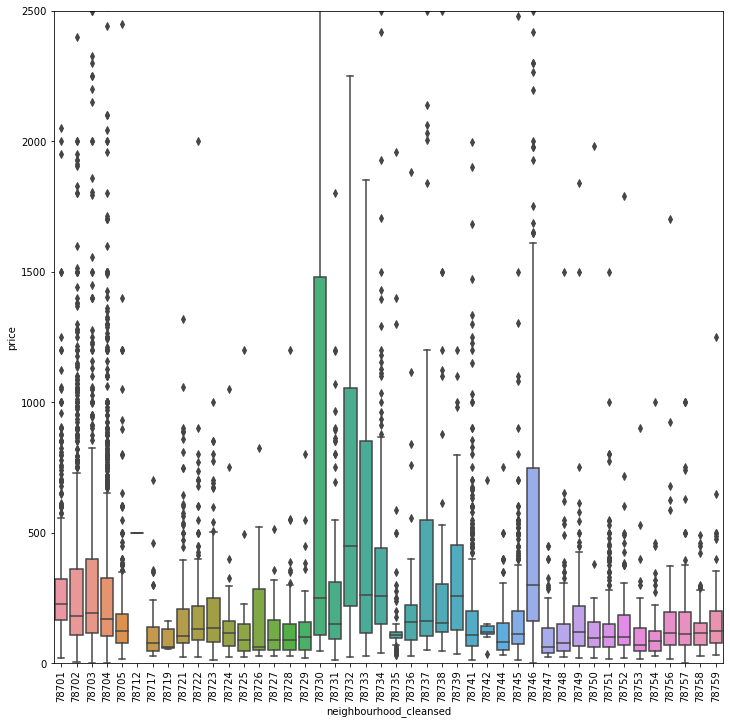

In [26]:
plt.figure(figsize =(12, 12))
sns.boxplot(x='neighbourhood_cleansed', y='price', data=clean_to_keep)
plt.ylim((0,2500))
plt.xticks(rotation=90);

In [27]:
neighborhoods = pd.get_dummies(clean_to_keep['neighbourhood_cleansed'])
neighborhoods

,78701,78702,78703,78704,78705,78712,78717,78719,78721,78722,...,78749,78750,78751,78752,78753,78754,78756,78757,78758,78759
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10107,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
zipcode = pd.DataFrame()

In [29]:
zipcode['78701'] = neighborhoods[78701]
zipcode['78702'] = neighborhoods[78702]
zipcode['78703'] = neighborhoods[78703]
zipcode['78704'] = neighborhoods[78704]
zipcode['78705'] = neighborhoods[78705]
zipcode['78720'] = neighborhoods.iloc[:,5:17].sum(axis=1)
zipcode['78730'] = neighborhoods.iloc[:,17:27].sum(axis=1)
zipcode['78740'] = neighborhoods.iloc[:,27:31].sum(axis=1)
zipcode['78746'] = neighborhoods[78746]
zipcode['78750'] = neighborhoods.iloc[:,32:38].sum(axis=1)
zipcode['78759'] = neighborhoods.iloc[:,38:44].sum(axis=1)

In [30]:
zipcode

,78701,78702,78703,78704,78705,78720,78730,78740,78746,78750,78759
0,0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
10104,0,0,0,0,0,0,0,1,0,0,0
10105,0,0,0,0,0,0,0,0,1,0,0
10106,0,0,0,0,0,0,0,0,1,0,0
10107,0,0,1,0,0,0,0,0,0,0,0


In [31]:
clean_to_keep['amenities']

0        ["Dining table", "Cleaning before checkout", "...
1        ["Lock on bedroom door", "Heating", "Dryer", "...
2        ["Free street parking", "Air conditioning", "H...
3        ["Heating", "Cooking basics", "Washer", "TV", ...
4        ["Heating", "Shampoo", "Fire extinguisher", "I...
                               ...                        
10104    ["Heating", "Dryer", "Iron", "Washer", "TV", "...
10105    ["Cooking basics", "Dryer", "Iron", "Washer", ...
10106    ["Cooking basics", "Dryer", "Iron", "Washer", ...
10107    ["Pack \u2019n Play/travel crib", "Heating", "...
10108    ["Long term stays allowed", "Hair dryer", "Bod...
Name: amenities, Length: 10109, dtype: object

In [32]:
test_amen = clean_to_keep['amenities'].str.replace('[^\w\s]',' ').str.split('    ')
test_amen = test_amen.apply(lambda x: [item.strip() for item in x])
test_amen

/home/reza/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


0        [Dining table, Cleaning before checkout, Centr...
1        [Lock on bedroom door, Heating, Dryer, Iron, W...
2        [Free street parking, Air conditioning, Hanger...
3        [Heating, Cooking basics, Washer, TV, Luggage ...
4        [Heating, Shampoo, Fire extinguisher, Indoor f...
                               ...                        
10104    [Heating, Dryer, Iron, Washer, TV, Hair dryer,...
10105    [Cooking basics, Dryer, Iron, Washer, TV, Show...
10106    [Cooking basics, Dryer, Iron, Washer, TV, Show...
10107    [Pack  u2019n Play travel crib, Heating, Cooki...
10108    [Long term stays allowed, Hair dryer, Body soa...
Name: amenities, Length: 10109, dtype: object

In [33]:
amenities_dict = dict()
for ind, item in zip(test_amen.index, test_amen.values):
    for amenity in item:
        if amenity in amenities_dict.keys():
            amenities_dict[amenity] += 1
        else:
            amenities_dict[amenity] = 1
sorted_amenities = sorted(amenities_dict.items(), key=lambda x: x[1], reverse=True)  
sorted_amenities

[('Wifi', 9733),
 ('Air conditioning', 9595),
 ('Smoke alarm', 9407),
 ('Heating', 9295),
 ('Essentials', 9208),
 ('Kitchen', 9202),
 ('Free parking on premises', 8247),
 ('Washer', 7968),
 ('Dryer', 7914),
 ('Shampoo', 7797),
 ('Hangers', 7746),
 ('Long term stays allowed', 7739),
 ('Hair dryer', 7401),
 ('Iron', 7282),
 ('Carbon monoxide alarm', 6983),
 ('Fire extinguisher', 6925),
 ('Dedicated workspace', 6757),
 ('TV', 6299),
 ('Hot water', 6198),
 ('Coffee maker', 5613),
 ('Dishes and silverware', 5535),
 ('Refrigerator', 5453),
 ('Microwave', 5281),
 ('Cooking basics', 5025),
 ('Private entrance', 4749),
 ('Stove', 4669),
 ('Oven', 4653),
 ('First aid kit', 4345),
 ('Dishwasher', 4252),
 ('Bed linens', 4243),
 ('Free street parking', 4034),
 ('Patio or balcony', 4025),
 ('Extra pillows and blankets', 3318),
 ('Pool', 3166),
 ('Backyard', 3078),
 ('Cable TV', 2520),
 ('TV with standard cable', 2286),
 ('BBQ grill', 2098),
 ('Gym', 2079),
 ('Bathtub', 1989),
 ('Keypad', 1966),
 ('L

In [34]:
amenities = pd.DataFrame()
amenities['tv'] = clean_to_keep['amenities'].str.lower().apply(lambda x: 1 if 'tv' in x else 0)
amenities['washer_dryer'] = clean_to_keep['amenities'].str.lower().apply(lambda x: 1 if '"washer"' in x or '"dryer"' in x else 0)
amenities['long_term'] = clean_to_keep['amenities'].str.lower().apply(lambda x: 1 if 'long term' in x else 0)
amenities['refrigerator'] = clean_to_keep['amenities'].str.lower().apply(lambda x: 1 if 'refrigerator' in x else 0)
amenities['private_entrance'] = clean_to_keep['amenities'].str.lower().apply(lambda x: 1 if 'private entrance' in x else 0)
amenities['dishwasher'] = clean_to_keep['amenities'].str.lower().apply(lambda x: 1 if '"dishwasher"' in x else 0)
amenities['balcony'] = clean_to_keep['amenities'].str.lower().apply(lambda x: 1 if 'patio' in x or 'balcony' in x else 0)
amenities['yard'] = clean_to_keep['amenities'].str.lower().apply(lambda x: 1 if 'yard' in x else 0)
amenities['pool'] = clean_to_keep['amenities'].str.lower().apply(lambda x: 1 if '"pool"' in x else 0)
amenities['bbq'] = clean_to_keep['amenities'].str.lower().apply(lambda x: 1 if 'bbq' in x or 'barbeque' in x else 0)
amenities['gym'] = clean_to_keep['amenities'].str.lower().apply(lambda x: 1 if 'gym' in x else 0)
amenities['single_level'] = clean_to_keep['amenities'].str.lower().apply(lambda x: 1 if 'single level' in x else 0)
amenities['breakfast'] = clean_to_keep['amenities'].str.lower().apply(lambda x: 1 if '"breakfast"' in x else 0)
amenities['hottub'] = clean_to_keep['amenities'].str.lower().apply(lambda x: 1 if 'hot tub' in x else 0)
amenities['lake_access'] = clean_to_keep['amenities'].str.lower().apply(lambda x: 1 if 'lake access' in x else 0)

In [35]:
amenities

,tv,washer_dryer,long_term,refrigerator,private_entrance,dishwasher,balcony,yard,pool,bbq,gym,single_level,breakfast,hottub,lake_access
0,1,0,1,1,1,1,1,1,0,0,0,1,1,0,0
1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0
2,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0
3,1,1,1,1,1,0,1,1,0,1,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10104,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0
10105,1,1,1,1,1,1,1,0,1,1,1,0,0,0,0
10106,1,1,1,1,1,1,1,0,1,1,1,0,0,0,0
10107,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0


In [36]:
clean_to_keep.drop(columns=['neighbourhood_cleansed', 'amenities'], inplace=True)
clean_to_keep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10109 entries, 0 to 10108
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_is_superhost               10109 non-null  bool   
 1   host_identity_verified          10109 non-null  bool   
 2   accommodates                    10109 non-null  int64  
 3   bedrooms                        9425 non-null   float64
 4   beds                            9886 non-null   float64
 5   price                           10109 non-null  float64
 6   minimum_nights                  10109 non-null  int64  
 7   maximum_nights                  10109 non-null  int64  
 8   availability_90                 10109 non-null  int64  
 9   availability_365                10109 non-null  int64  
 10  number_of_reviews               10109 non-null  int64  
 11  number_of_reviews_l30d          10109 non-null  int64  
 12  review_scores_rating            

In [37]:
all_listings = pd.concat([clean_to_keep.drop(columns='price'), zipcode, amenities], axis=1)
all_listings['price'] = clean_to_keep['price']

In [38]:
listings = all_listings[(all_listings['price'] >= 10) & (all_listings['price'] < 2500)]

In [39]:
listings = listings.dropna()
listings.describe()

,accommodates,bedrooms,beds,minimum_nights,maximum_nights,availability_90,availability_365,number_of_reviews,number_of_reviews_l30d,review_scores_rating,...,balcony,yard,pool,bbq,gym,single_level,breakfast,hottub,lake_access,price
count,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,...,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000,6915.000000
mean,4.783514,1.935069,2.598409,6.748807,617.345192,26.296746,110.158062,39.703398,0.936515,95.785249,...,0.465799,0.398265,0.259725,0.216920,0.145625,0.156182,0.114389,0.067534,0.059581,220.038612
std,3.158088,1.219351,2.340602,21.307584,522.579546,29.943446,125.343341,68.947051,1.776617,8.017086,...,0.498865,0.489576,0.438516,0.412177,0.352756,0.363054,0.318306,0.250963,0.236725,258.383634
min,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,20.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000
25%,2.000000,1.000000,1.000000,1.000000,30.000000,0.000000,0.000000,4.000000,0.000000,95.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,80.000000
50%,4.000000,2.000000,2.000000,2.000000,1124.000000,12.000000,57.000000,13.000000,0.000000,98.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,139.000000
75%,6.000000,3.000000,3.000000,3.000000,1125.000000,51.000000,214.000000,45.000000,1.000000,100.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,249.000000
max,16.000000,15.000000,39.000000,999.000000,1825.000000,90.000000,365.000000,891.000000,33.000000,100.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2442.000000


<AxesSubplot:>

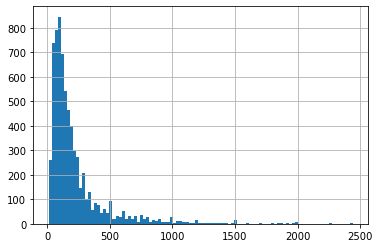

In [40]:
listings['price'].hist(bins=100)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(listings.drop(columns='price'), 
                                                    listings['price'], 
                                                    test_size=0.1,
                                                    random_state=1)

In [42]:
X_train

,host_is_superhost,host_identity_verified,accommodates,bedrooms,beds,minimum_nights,maximum_nights,availability_90,availability_365,number_of_reviews,...,dishwasher,balcony,yard,pool,bbq,gym,single_level,breakfast,hottub,lake_access
928,True,True,9,3.0,3.0,1,30,0,0,12,...,1,1,1,0,0,0,1,0,0,0
3390,False,True,5,2.0,2.0,1,1124,62,240,233,...,1,1,1,0,1,0,0,0,0,0
1022,True,True,5,2.0,4.0,4,30,8,214,393,...,1,0,1,0,0,0,0,0,0,0
898,True,True,2,1.0,1.0,1,10,60,60,17,...,1,1,0,1,0,1,0,0,0,1
3073,False,True,2,1.0,1.0,5,1125,0,0,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,False,True,3,1.0,1.0,1,1125,0,0,96,...,0,0,0,0,0,0,0,0,0,0
7070,False,False,4,2.0,2.0,2,6,0,0,2,...,0,0,0,0,0,0,0,0,0,0
5469,False,True,6,3.0,3.0,2,8,0,0,12,...,0,0,0,0,0,0,0,0,0,0
277,False,True,2,1.0,1.0,1,6,0,0,7,...,0,0,0,0,0,0,0,0,0,0


In [43]:
def model_scores(model, X_train, X_test, y_train, y_test):
    print(f'R2 train: {model.score(X_train, y_train): 4f}')
    print(f'R2 test: {model.score(X_test, y_test): 4f}')
    print(f'rmse train: {np.sqrt(mean_squared_error(y_train, model.predict(X_train))): 4f}')
    print(f'rmse test: {np.sqrt(mean_squared_error(y_test, model.predict(X_test))): 4f}')

In [44]:
def plot_price_predict(model, X_train, X_test, y_train, y_test):
    fig, ax = plt.subplots(1, 2, figsize=(12,6));
    ax[0].scatter(model.predict(X_train),y_train,alpha=0.3);
    ax[0].plot([0,2000],[0,2000],color='r',ls='--');
    ax[0].set_xlabel('Predicted Price');
    ax[0].set_ylabel('Listing Price');
    for item in ([ax[0].title, ax[0].xaxis.label, ax[0].yaxis.label] +
                 ax[0].get_xticklabels() + ax[0].get_yticklabels() ):
        item.set_fontsize(12)
    
    ax[1].scatter(model.predict(X_test),y_test,alpha=0.3);
    ax[1].plot([0,2000],[0,2000],color='r',ls='--');
    ax[1].set_xlabel('Predicted Price');
    ax[1].set_ylabel('Listing Price');
    for item in ([ax[1].title, ax[1].xaxis.label, ax[1].yaxis.label] +
                 ax[1].get_xticklabels() + ax[1].get_yticklabels() ):
        item.set_fontsize(12)

In [45]:
lr = LinearRegression()
lr.fit(X_train, y_train)
cross_val_score(lr, X_train, y_train).mean()

0.5914941970461152

In [46]:
lr.predict(X_test)

array([ 3.14094341e+01,  5.40130591e+02,  1.68422267e+02,  5.81346152e-01,
       -1.14168082e+01,  7.08193749e+01,  1.63025540e+02,  1.10061826e+00,
        6.63156886e+01,  4.39871618e+02,  5.07578651e+02,  1.96894217e+02,
        7.88664474e+02, -1.27621563e+01,  1.62557247e+02,  7.58564749e+01,
        3.03059087e+02,  5.20247520e+02,  3.27225412e+01,  1.58974860e+03,
        2.71247196e+02,  4.60148314e+00,  4.32880272e+01,  3.54700082e+02,
        7.13558895e+02,  9.28896806e+01,  1.40401325e+02,  8.54186020e+02,
        2.45033989e+02,  2.07485324e+02,  1.84040470e+01,  3.90296996e+02,
        4.74476254e+01, -6.03470979e-01,  3.12433111e+01,  2.44116875e+02,
        6.02280402e+02, -6.71139357e+00,  2.52997887e+01,  1.48827907e+01,
        3.89027880e+02,  6.90435926e+01,  4.77935311e+02,  5.56053435e+02,
        1.09148445e+02,  4.67777625e+02,  2.25569813e+02,  3.22299361e+02,
        2.69881408e+02,  1.89354619e+02,  2.75578901e+02, -7.18162530e+01,
        4.58182629e+02,  

In [47]:
lr.score(X_test, y_test)

0.5527849979152444

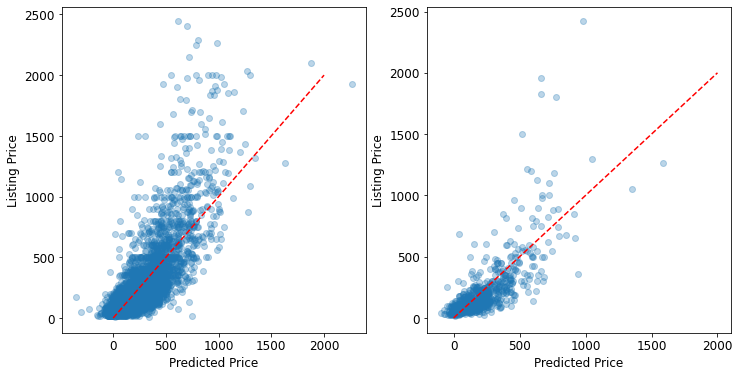

In [48]:
plot_price_predict(lr, X_train, X_test, y_train, y_test)

In [49]:
dtr = DecisionTreeRegressor(random_state=1)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(random_state=1)

In [50]:
model_scores(dtr, X_train, X_test, y_train, y_test)

R2 train:  0.999956
R2 test:  0.104800
rmse train:  1.721022
rmse test:  235.172511


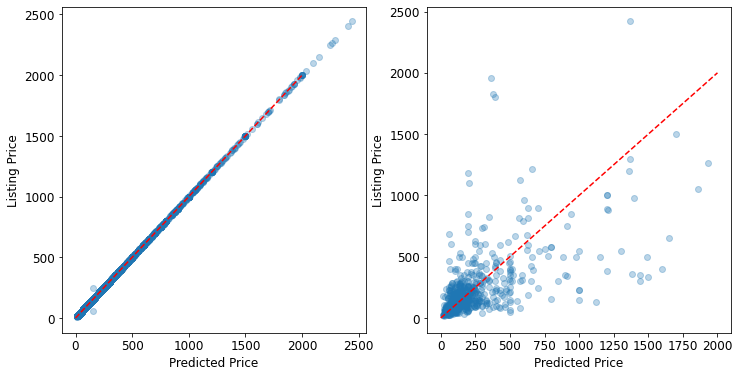

In [51]:
plot_price_predict(dtr, X_train, X_test, y_train, y_test)

In [52]:
rfr = RandomForestRegressor(n_estimators=200, max_features=10, random_state=1)
rfr.fit(X_train, y_train)

RandomForestRegressor(max_features=10, n_estimators=200, random_state=1)

In [53]:
model_scores(rfr, X_train, X_test, y_train, y_test)

R2 train:  0.955232
R2 test:  0.648476
rmse train:  54.891915
rmse test:  147.368364


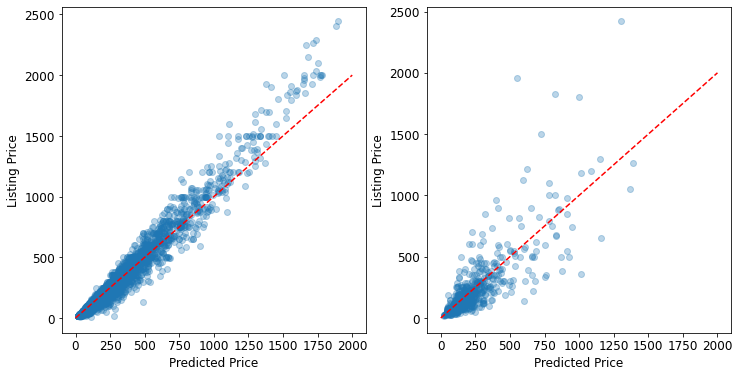

In [54]:
plot_price_predict(rfr, X_train, X_test, y_train, y_test)

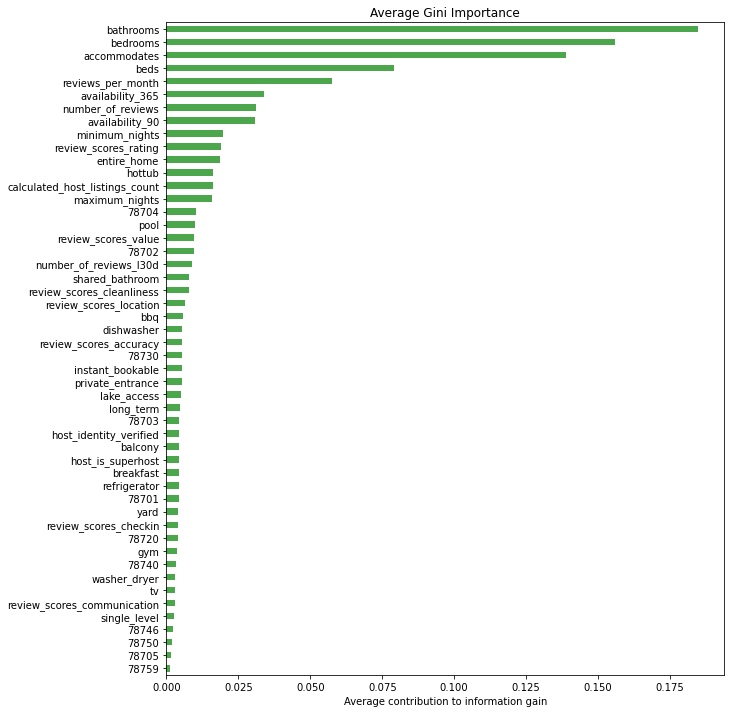

In [55]:
feature_scores = pd.Series(rfr.feature_importances_, 
                           index=X_train.columns)
feature_scores = feature_scores.sort_values()
ax = feature_scores.plot(kind='barh', 
                         figsize=(10,12), 
                         color='g',alpha=0.7)
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');

In [56]:
rfr_gs_trial_best = RandomForestRegressor(bootstrap=False, max_depth=8, 
                                          max_features='sqrt', n_estimators=200, 
                                          n_jobs=-1, random_state=1)

In [57]:
rfr_gs_trial_best.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=8, max_features='sqrt',
                      n_estimators=200, n_jobs=-1, random_state=1)

In [58]:
model_scores(rfr_gs_trial_best, X_train, X_test, y_train, y_test)

R2 train:  0.789237
R2 test:  0.624802
rmse train:  119.102674
rmse test:  152.249740


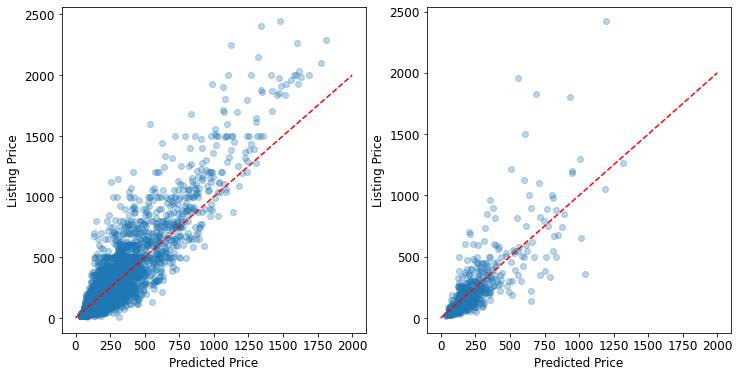

In [59]:
plot_price_predict(rfr_gs_trial_best, X_train, X_test, y_train, y_test)

In [60]:
grid_rfr = {'n_estimators': [200, 600, 1000, 1400, 1800], 
            'max_depth': [4, 8, 16, 32], 
            'min_samples_split': [2, 8, 16], 
            'max_features': [4, 16, 32],
            'max_leaf_nodes':[4 ,16 ,32]}

In [61]:
# rfr_gs = RandomForestRegressor(n_estimators=200, 
#                                max_depth=4, 
#                                min_samples_split=2, 
#                                max_features=4, 
#                                max_leaf_nodes=4, 
#                                oob_score=True, 
#                                n_jobs=-1, 
#                                random_state=1)
# rfr_gs_cv = GridSearchCV(rfr_gs, 
#                          grid_rfr, 
#                          return_train_score=True)

In [62]:
# rfr_gs_cv.fit(X_train, y_train)

In [63]:
# rfr_gs_cv.best_estimator_

In [64]:
rfr_gs_cv_best = RandomForestRegressor(max_depth=16, max_features=16, max_leaf_nodes=32, 
                                       min_samples_split=16, n_estimators=600, n_jobs=-1, 
                                       oob_score=True, random_state=1)

In [65]:
rfr_gs_cv_best.fit(X_train, y_train)

RandomForestRegressor(max_depth=16, max_features=16, max_leaf_nodes=32,
                      min_samples_split=16, n_estimators=600, n_jobs=-1,
                      oob_score=True, random_state=1)

In [66]:
model_scores(rfr_gs_cv_best, X_train, X_test, y_train, y_test)

R2 train:  0.707446
R2 test:  0.594805
rmse train:  140.322437
rmse test:  158.218924


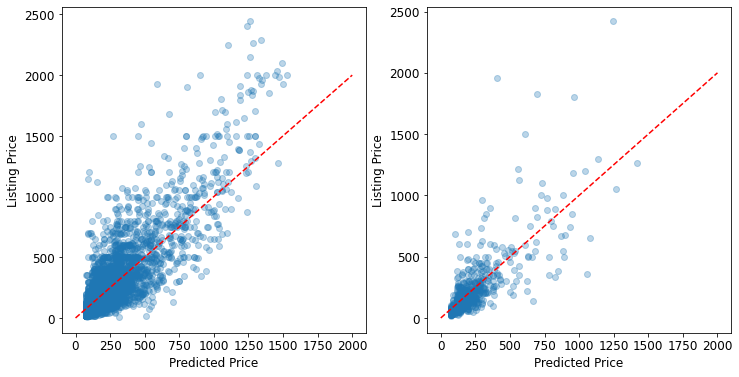

In [67]:
plot_price_predict(rfr_gs_cv_best, X_train, X_test, y_train, y_test)

In [68]:
gbr = GradientBoostingRegressor(n_estimators=1000)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=1000)

In [69]:
model_scores(gbr, X_train, X_test, y_train, y_test)

R2 train:  0.909294
R2 test:  0.652580
rmse train:  78.134343
rmse test:  146.505478


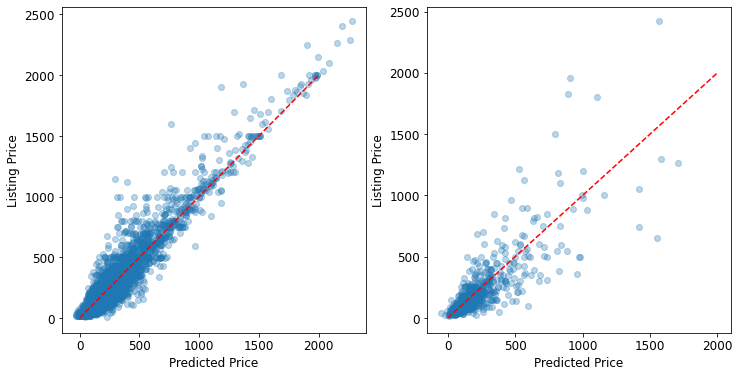

In [70]:
plot_price_predict(gbr, X_train, X_test, y_train, y_test)

In [71]:
grid_gbr = {'learning_rate': [0.01, 0.02, 0.05, 0.1], 
            'max_depth':[2, 4, 8, 12, 16, 24], 
            'min_samples_split':[2, 4, 6, 8, 10], 
            'max_features': [0.1, 0.3, 1.0], 
            'n_estimators': [1000, 2000]}

In [72]:
# gbr_gs = GradientBoostingRegressor(n_estimators=2000, 
#                                    learning_rate=0.1, 
#                                    max_depth=4, 
#                                    min_samples_split=2, 
#                                    max_features=0.1, 
#                                    random_state=1)
# gbr_gs_cv = GridSearchCV(gbr_gs, 
#                          grid_gbr, 
#                          return_train_score=True)

In [73]:
# gbr_gs_cv.fit(X_train, y_train)

In [74]:
# gbr_gs_cv.best_estimator_

In [75]:
gbr_gs_cv_best = GradientBoostingRegressor(learning_rate=0.02, max_depth=8, 
                                           max_features=0.1, min_samples_split=10, 
                                           n_estimators=1000, random_state=1)

In [76]:
gbr_gs_cv_best.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.02, max_depth=8, max_features=0.1,
                          min_samples_split=10, n_estimators=1000,
                          random_state=1)

In [77]:
model_scores(gbr_gs_cv_best, X_train, X_test, y_train, y_test)

R2 train:  0.974894
R2 test:  0.691008
rmse train:  41.106938
rmse test:  138.165685


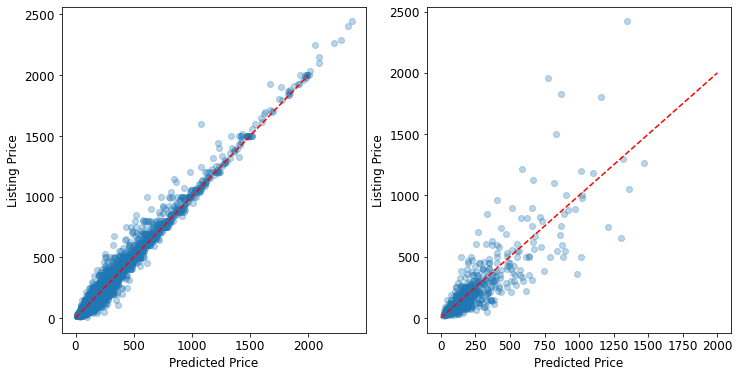

In [78]:
plot_price_predict(gbr_gs_cv_best, X_train, X_test, y_train, y_test)

In [79]:
xgbr = XGBRegressor(random_state=1)

In [80]:
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [81]:
model_scores(xgbr, X_train, X_test, y_train, y_test)

R2 train:  0.971800
R2 test:  0.638243
rmse train:  43.565801
rmse test:  149.497788


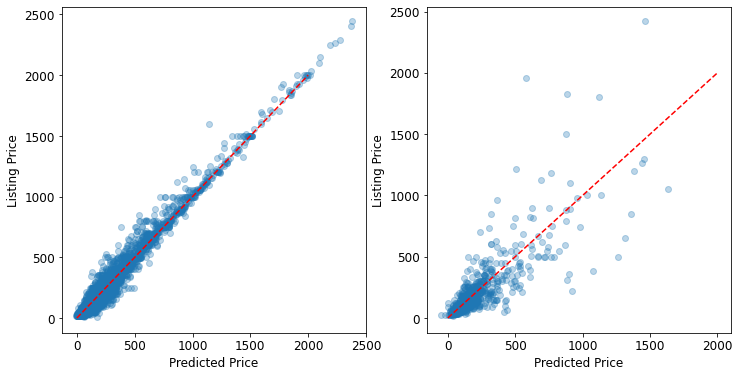

In [82]:
plot_price_predict(xgbr, X_train, X_test, y_train, y_test)

In [83]:
xgbr.feature_importances_

array([0.0033045 , 0.00508192, 0.03471353, 0.25279933, 0.01426798,
       0.01638179, 0.00799938, 0.01593573, 0.0108796 , 0.01047866,
       0.00316929, 0.00949765, 0.01131363, 0.01514586, 0.01140756,
       0.01395604, 0.0037989 , 0.0114047 , 0.00518586, 0.00973282,
       0.02114453, 0.03862477, 0.00802203, 0.12230321, 0.02106559,
       0.02601531, 0.00881634, 0.02267663, 0.00716692, 0.02504216,
       0.0180319 , 0.02024888, 0.00819203, 0.00380992, 0.0060111 ,
       0.00888805, 0.007887  , 0.01106073, 0.00953018, 0.00578066,
       0.00956185, 0.00609309, 0.00833362, 0.02171168, 0.00615119,
       0.00924609, 0.00434856, 0.00747711, 0.03480744, 0.02549671],
      dtype=float32)

In [84]:
X_train.shape

(6223, 50)

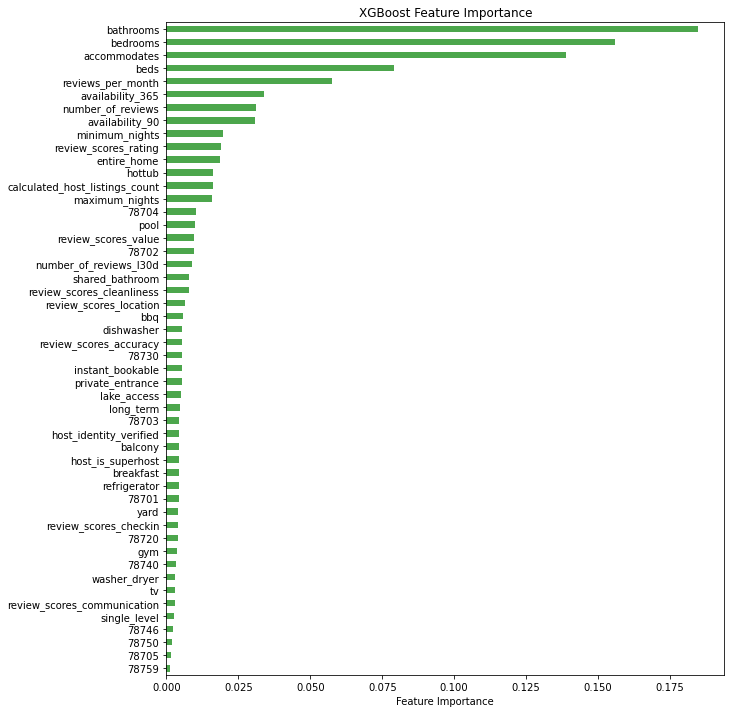

In [85]:
feature_importance_xgbr = pd.Series(xgbr.feature_importances_, 
                                    index=X_train.columns)
feature_importance_xgbr = feature_importance_xgbr.sort_values()
ax = feature_scores.plot(kind='barh', 
                         figsize=(10,12), 
                         color='g',alpha=0.7)
ax.set_title('XGBoost Feature Importance')
ax.set_xlabel('Feature Importance');

In [86]:
xgbr_important_features = XGBRegressor(random_state=1)
score_xgbr_important_features = cross_val_score(xgbr_important_features, 
                                                X_train,
                                                y_train,
                                                cv=2, n_jobs=-1)

In [87]:
np.mean(score_xgbr_important_features)

0.6195828167207026

In [223]:
xgbr_01 = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
                       importance_type='gain', interaction_constraints='',
                       learning_rate=0.3, max_delta_step=0, max_depth=5,
                       min_child_weight=1, monotone_constraints='()',
                       n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=1,
                       reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1, subsample=1,
                       tree_method='exact', validate_parameters=1, verbosity=None)

In [224]:
xgbr_01.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=1,
             reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [225]:
model_scores(xgbr_01, X_train, X_test, y_train, y_test)

R2 train:  0.939527
R2 test:  0.682403
rmse train:  63.797753
rmse test:  140.076392


In [305]:
listings_new = listings[~((listings['number_of_reviews_l30d']<2) & 
                          (listings['availability_90']<40) & 
                          (listings['price']>200))]

In [306]:
listings_new

,host_is_superhost,host_identity_verified,accommodates,bedrooms,beds,minimum_nights,maximum_nights,availability_90,availability_365,number_of_reviews,...,balcony,yard,pool,bbq,gym,single_level,breakfast,hottub,lake_access,price
0,False,True,4,2.0,2.0,7,180,60,150,25,...,1,1,0,0,0,1,1,0,0,200.0
1,False,True,2,1.0,2.0,30,60,0,0,9,...,0,0,0,0,0,0,1,0,0,114.0
2,True,True,3,1.0,2.0,2,90,65,326,548,...,1,1,0,0,0,0,0,0,0,104.0
3,False,False,1,1.0,3.0,30,60,31,31,22,...,1,1,0,1,0,0,0,0,0,46.0
4,True,True,2,1.0,1.0,1,14,7,7,262,...,0,0,0,0,0,0,0,0,0,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10026,False,True,6,3.0,3.0,1,1125,21,39,2,...,1,1,0,1,0,0,0,0,0,316.0
10029,False,False,4,1.0,2.0,1,1125,68,343,1,...,0,0,0,1,0,0,0,0,0,123.0
10033,False,True,4,2.0,2.0,3,10,21,35,1,...,1,0,0,0,0,0,0,0,0,159.0
10089,False,True,6,2.0,2.0,1,365,83,358,1,...,0,0,1,1,1,0,0,0,0,224.0


In [307]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    listings_new.drop(columns='price'), 
    listings_new['price'], 
    test_size=0.1, 
    random_state=1)

In [308]:
xgbr_new = XGBRegressor(max_depth=5, random_state=1)

In [309]:
xgbr_new.fit(X_train_new, y_train_new)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [310]:
model_scores(xgbr_new, X_train_new, X_test_new, y_train_new, y_test_new)

R2 train:  0.972646
R2 test:  0.782801
rmse train:  35.337826
rmse test:  113.438995


In [311]:
xgbr_new = XGBRegressor(max_depth=5, random_state=1)
xgbr_new_cv_score = cross_val_score(xgbr_new, 
                                    X_train_new, 
                                    y_train_new, 
                                    cv=5, n_jobs=-1)

In [312]:
xgbr_new_cv_score

array([0.71755631, 0.74807898, 0.75385855, 0.67889414, 0.66904801])

In [288]:
cross_validate(xgbr_new, 
               X_train_new, 
               y_train_new, 
               cv=5, n_jobs=-1)

{'fit_time': array([4.42321777, 3.95227766, 5.10726738, 4.87183642, 1.68287539]),
 'score_time': array([0.0900259 , 0.03159142, 0.03649211, 0.05478835, 0.01363349]),
 'test_score': array([0.68369453, 0.71495325, 0.72427262, 0.73457056, 0.67270484])}

In [289]:
model_scores(xgbr_new, X_train_new, X_test_new, y_train_new, y_test_new)

NotFittedError: need to call fit or load_model beforehand

In [286]:
xgbr_new

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=5,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=1, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)